# Preliminary Test on Orbit ARMA Model

In [1]:
from datetime import datetime, timedelta
import datetime as dt 

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape

In [2]:
%load_ext autoreload
%autoreload 2

## Data Simulation

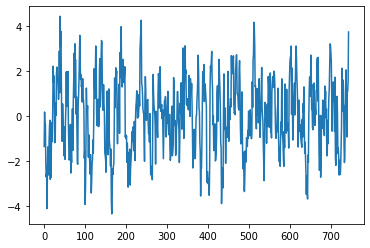

In [3]:
# make the data
n = 744 # hourly for 1 year 


eta = np.random.normal(0, 1.0, n)

rho = [0.60, -0.35]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-24] +eta[i]
    #y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-3]  + rho[3]*y[i-4] + rho[4]*y[i-5] eta[i]

     
#plt.plot(y)
plt.plot(y)


In [4]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]

In [5]:
df = pd.DataFrame()
df['hours'] = hours
df['y'] = y

In [6]:
df_train = df[0:180]
df_test = df[180:n]

In [7]:
df_test

,hours,y
180,2021-01-08 12:00:00,0.340509
181,2021-01-08 13:00:00,-0.007345
182,2021-01-08 14:00:00,1.189902
183,2021-01-08 15:00:00,1.414351
184,2021-01-08 16:00:00,-0.765127
...,...,...
739,2021-01-31 19:00:00,-0.926968
740,2021-01-31 20:00:00,1.047320
741,2021-01-31 21:00:00,1.120541
742,2021-01-31 22:00:00,1.512484


## Prediction Comparison orbit-ml vs. statsmodels

### AR1 

In [8]:
mod = ARMA(
        level_first=0,
        estimator='stan-mcmc',
        date_col='hours',
        response_col='y',
        ma_lags = [1] ,
        ar_lags = [1,24],
    num_warmup=3000,
    num_sample=3000,
)
mod.fit(df_train)
pred = mod.predict(df_test)
pred = pred.rename(columns={
    'prediction': 'prediction_orbit',
    'prediction_5': 'prediction_5_orbit',
    'prediction_95': 'prediction_95_orbit',
})

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9c146943f71c5a541b66bd85af2aaca NOW.
In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:771:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/9f/m35pbwgx1

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:781:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long long, 2521

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_x_1pj_jy/stanfit4anon_model_d9c146943f71c5a541b66bd85af2aaca_6627044977363052092.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

152 warnings generated.
INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):750 and samples(per chain):750.


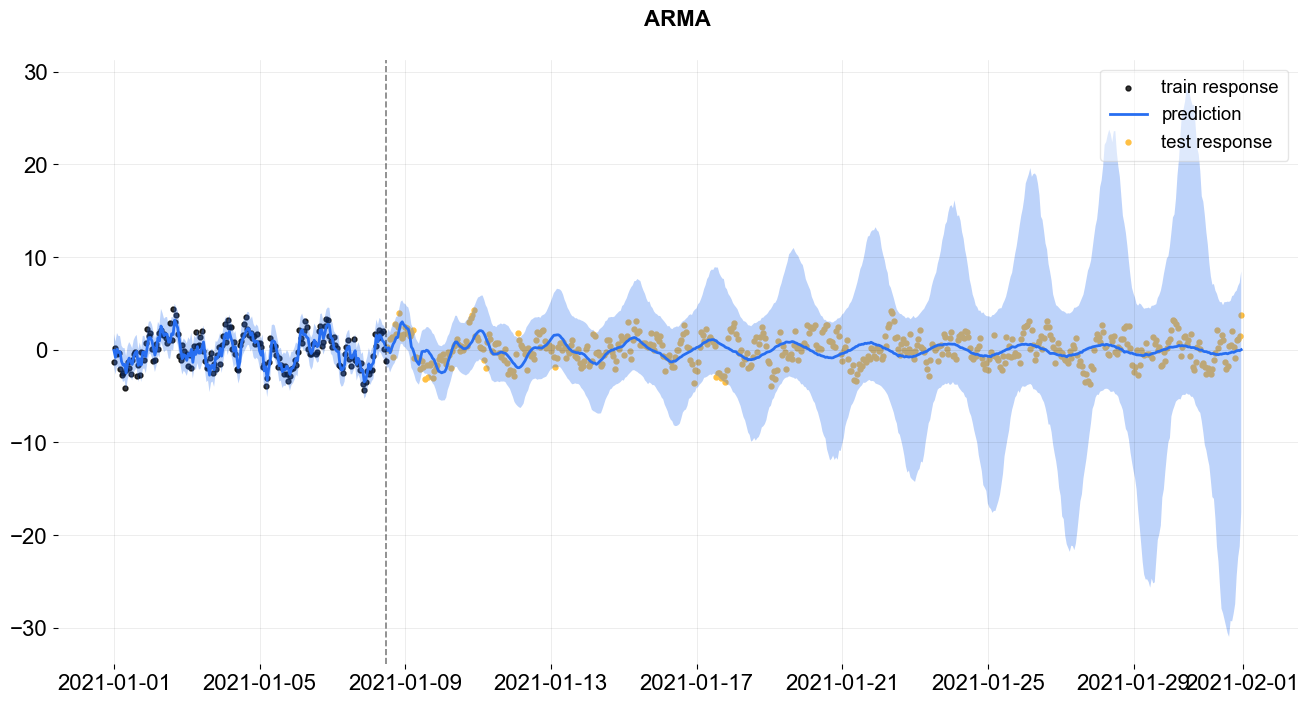

In [9]:
pred = mod.predict(df)
_ = plot_predicted_data(df_train, pred, date_col = 'hours', actual_col = 'y', title='ARMA', test_actual_df = df_test)

In [16]:
mod = ARMA(
        level_first=0,
        estimator='stan-mcmc',
        date_col='hours',
        response_col='y',
        ar_lags = [1],
    num_warmup=3000,
    num_sample=3000,
)
mod.fit(df_train)
pred = mod.predict(df_test)
pred = pred.rename(columns={
    'prediction': 'prediction_orbit',
    'prediction_5': 'prediction_5_orbit',
    'prediction_95': 'prediction_95_orbit',
})

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):750 and samples(per chain):750.


In [17]:
y = pd.Series(df_train['y'])
arma_mod = ARIMA(y, order=(0, 0, 1))
arma_res = arma_mod.fit()
forecast = arma_res.get_forecast(185)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.10)
pred['prediction_5_statsmodel'] = yhat_conf_int['lower y']
pred['prediction_statsmodel'] = yhat
pred['prediction_95_statsmodel'] = yhat_conf_int['upper y']

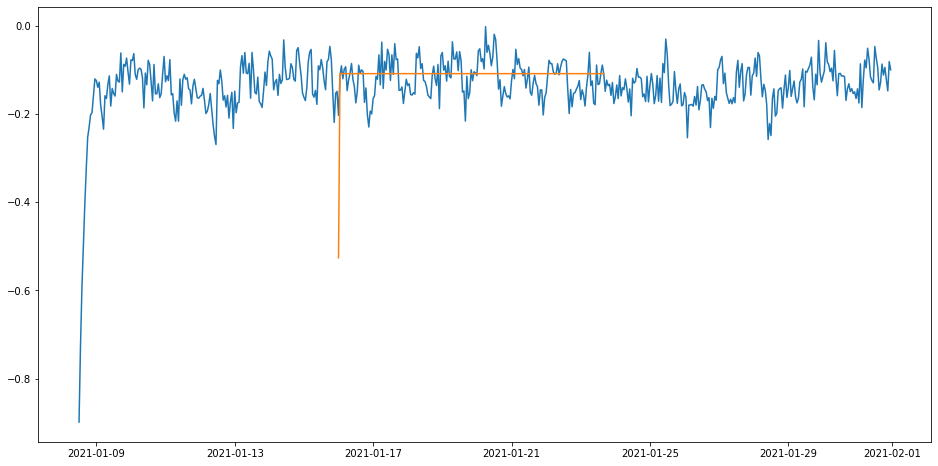

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(pred['hours'], pred['prediction_orbit'], label='orbit')
ax.plot(pred['hours'], pred['prediction_statsmodel'], label='statsmodel')